In [1]:
import sys

from src.dataset import TIME_STEP, X_TIME

PWD = '../..'
sys.path.append(PWD)

import pickle
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from src.cfd import CFD, find_optimal_cfd_threshold
from src.gauss_hist import get_gauss_stats
from src.network_utils import train_model as _base_train_model, plot_history, plot_difference_hist, compare_results, \
    dist_kernel, get_dist_root

In [2]:
N_JOBS = 16

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'

PLANE = 2
CHANNEL = 11

PRINT_PCOV = False

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

all_X, all_y = dataset[(PLANE, CHANNEL)][0], dataset[(PLANE, CHANNEL)][1]
all_X.shape, all_y.shape

((28015, 24), (28015,))

# Preprocess

In [4]:
N_BASELINE = 8

In [5]:
# turns out the networks do better without the normalisation, CFD has to use normalised waveforms anyway
# all_X -= np.mean(all_X[:, :N_BASELINE], axis=1)[:, None]
# all_X /= all_X.max(axis=1)[:, None]

X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21011, 24), (7004, 24), (21011,), (7004,))

# Utils

In [6]:
def train_model(model, name, X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test, lr=0.001, train=False,
                n_epochs=1000, verbose=2, batch_size=2048, lr_patience=None, es_patience=None, es_min_delta=0.01,
                loss_weights=None):
    return _base_train_model(model, name, 'basic_tests', X_train, y_train, X_val, y_val, lr, train, n_epochs, verbose,
                             batch_size, lr_patience, es_patience, es_min_delta, loss_weights, root=PWD + '/data')

# CFD

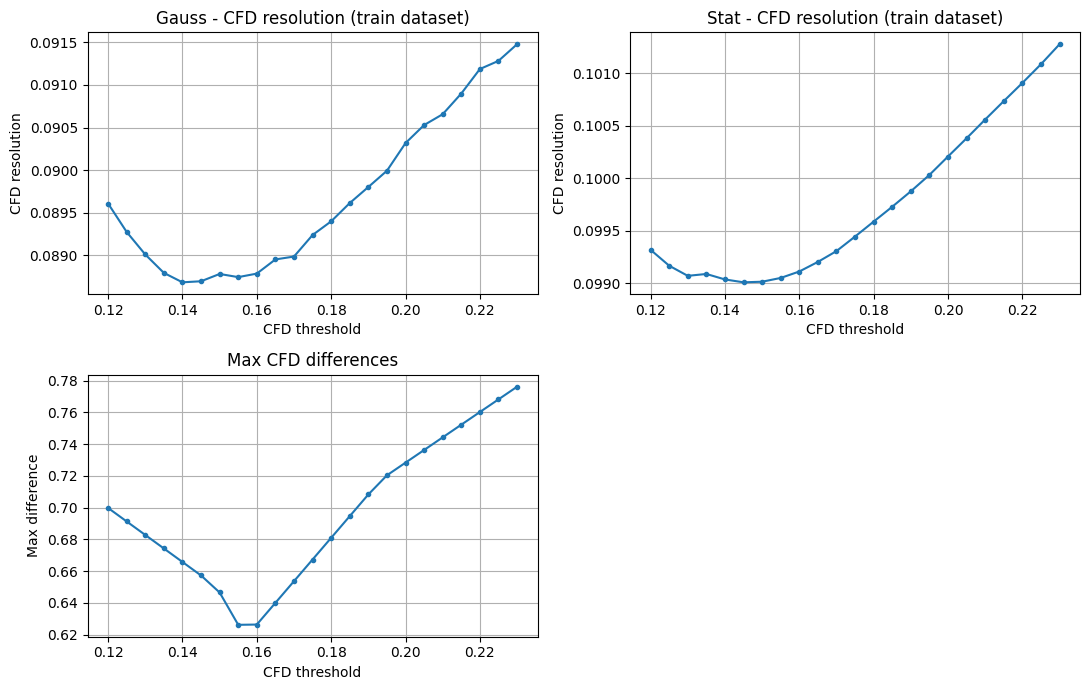

Optimal CFD threshold: 0.145


In [7]:
thresholds = np.arange(0.12, 0.23, 0.005)
optimal_cfd_threshold = find_optimal_cfd_threshold(thresholds, N_BASELINE, X_train, y_train, X_TIME, n_jobs=16)

In [8]:
cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_threshold)

y_pred = cfd.predict(X_TIME, X_test)

In [9]:
np.std(y_pred - y_test)

0.09986252482443399

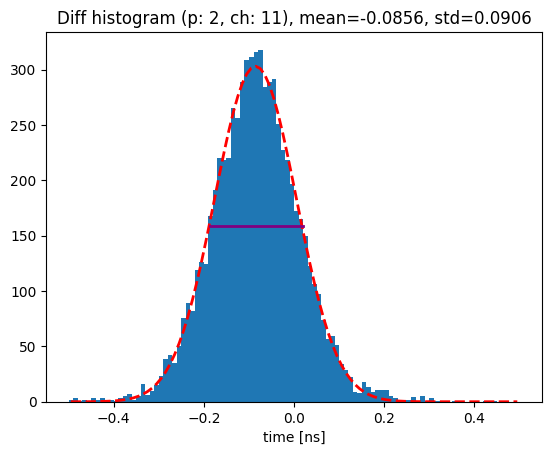

In [10]:
std_cfd_hist, pcov, fwhm_cfd = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_cfd_stat = np.std(y_pred - y_test)

# MLP 1

In [11]:
mlp_1_name = model_name = 'MLP 1'
model = keras.Sequential([
    layers.Input(24),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.1, train=False, n_epochs=3000, lr_patience=10, es_patience=60,
                      loss_weights=1000)

Epoch 1/3000
11/11 - 1s - loss: 898.6666 - val_loss: 18.2273 - lr: 0.1000 - 981ms/epoch - 89ms/step
Epoch 2/3000
11/11 - 0s - loss: 178.0150 - val_loss: 93.3276 - lr: 0.1000 - 30ms/epoch - 3ms/step
Epoch 3/3000
11/11 - 0s - loss: 83.8815 - val_loss: 75.2918 - lr: 0.1000 - 31ms/epoch - 3ms/step
Epoch 4/3000
11/11 - 0s - loss: 40.5248 - val_loss: 24.4269 - lr: 0.1000 - 27ms/epoch - 2ms/step
Epoch 5/3000
11/11 - 0s - loss: 21.9242 - val_loss: 19.5621 - lr: 0.1000 - 28ms/epoch - 3ms/step
Epoch 6/3000
11/11 - 0s - loss: 18.9096 - val_loss: 18.2338 - lr: 0.1000 - 28ms/epoch - 3ms/step
Epoch 7/3000
11/11 - 0s - loss: 17.1835 - val_loss: 16.9860 - lr: 0.1000 - 39ms/epoch - 4ms/step
Epoch 8/3000
11/11 - 0s - loss: 16.7271 - val_loss: 16.8877 - lr: 0.1000 - 37ms/epoch - 3ms/step
Epoch 9/3000
11/11 - 0s - loss: 16.3823 - val_loss: 16.7089 - lr: 0.1000 - 37ms/epoch - 3ms/step
Epoch 10/3000
11/11 - 0s - loss: 16.2554 - val_loss: 16.4825 - lr: 0.1000 - 37ms/epoch - 3ms/step
Epoch 11/3000
11/11 - 0s 

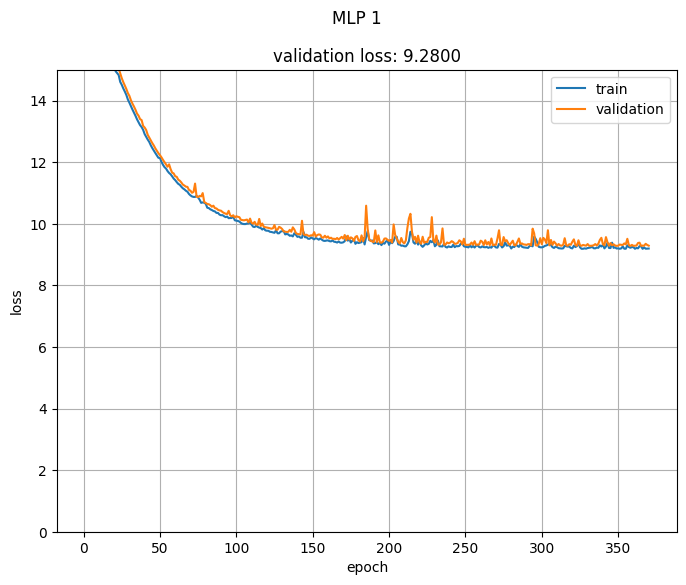

In [12]:
plot_history(history, model_name, ymax=15)

219/219 [==============================] - 0s 577us/step


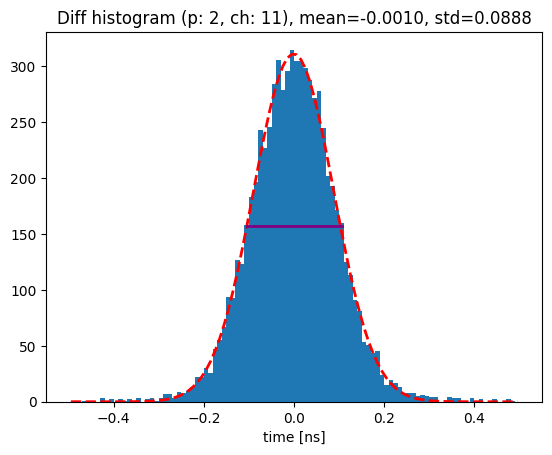

In [13]:
y_pred = model.predict(X_test)[:, 0]
std_1_hist, pcov, fwhm_1 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_1_stat = np.std(y_pred - y_test)

# MLP 2

In [14]:
mlp_2_name = model_name = 'MLP 2'
model = keras.Sequential([
    layers.Input(24),

    layers.Dense(24, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(6, activation='relu'),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=10, es_patience=60,
                      loss_weights=1000)

Epoch 1/3000
11/11 - 0s - loss: 308.2656 - val_loss: 19.7587 - lr: 0.0100 - 282ms/epoch - 26ms/step
Epoch 2/3000
11/11 - 0s - loss: 52.1998 - val_loss: 15.9226 - lr: 0.0100 - 56ms/epoch - 5ms/step
Epoch 3/3000
11/11 - 0s - loss: 26.7725 - val_loss: 18.8319 - lr: 0.0100 - 36ms/epoch - 3ms/step
Epoch 4/3000
11/11 - 0s - loss: 20.0951 - val_loss: 19.0624 - lr: 0.0100 - 39ms/epoch - 4ms/step
Epoch 5/3000
11/11 - 0s - loss: 17.0705 - val_loss: 17.0468 - lr: 0.0100 - 42ms/epoch - 4ms/step
Epoch 6/3000
11/11 - 0s - loss: 16.0635 - val_loss: 15.9045 - lr: 0.0100 - 56ms/epoch - 5ms/step
Epoch 7/3000
11/11 - 0s - loss: 15.5621 - val_loss: 15.7156 - lr: 0.0100 - 59ms/epoch - 5ms/step
Epoch 8/3000
11/11 - 0s - loss: 15.4442 - val_loss: 15.6207 - lr: 0.0100 - 56ms/epoch - 5ms/step
Epoch 9/3000
11/11 - 0s - loss: 15.3763 - val_loss: 15.5739 - lr: 0.0100 - 59ms/epoch - 5ms/step
Epoch 10/3000
11/11 - 0s - loss: 15.3401 - val_loss: 15.5633 - lr: 0.0100 - 57ms/epoch - 5ms/step
Epoch 11/3000
11/11 - 0s -

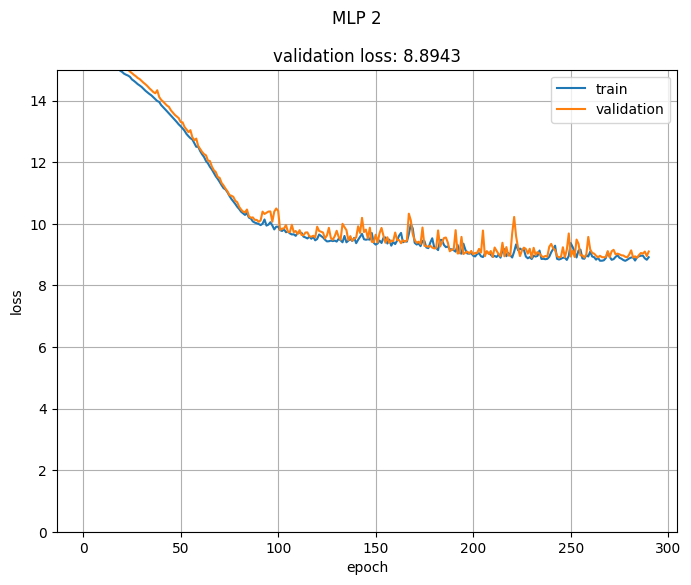

In [15]:
plot_history(history, model_name, ymax=15)

219/219 [==============================] - 0s 656us/step


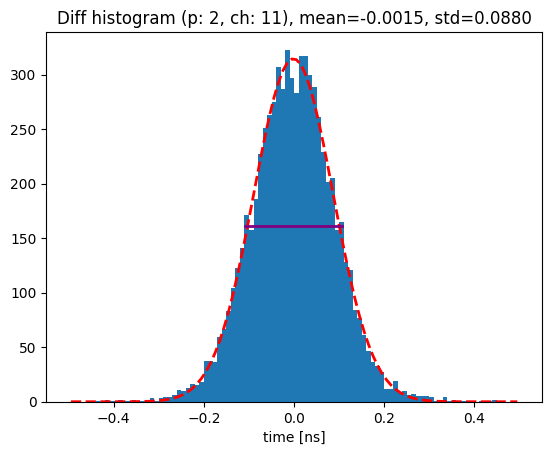

In [16]:
y_pred = model.predict(X_test)[:, 0]
std_2_hist, pcov, fwhm_2 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_2_stat = np.std(y_pred - y_test)

# Convolutional network 1

In [17]:
cnn_1_name = model_name = 'CNN 1'
model = keras.Sequential([
    layers.Input(24),
    layers.Reshape((-1, 1)),

    layers.Conv1D(16, 3, padding='same', activation='relu'),

    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=10, es_patience=60,
                      loss_weights=1000)

Epoch 1/3000
11/11 - 3s - loss: 617.3676 - val_loss: 68.9750 - lr: 0.0100 - 3s/epoch - 289ms/step
Epoch 2/3000
11/11 - 0s - loss: 71.2180 - val_loss: 18.8412 - lr: 0.0100 - 63ms/epoch - 6ms/step
Epoch 3/3000
11/11 - 0s - loss: 32.1583 - val_loss: 20.2409 - lr: 0.0100 - 46ms/epoch - 4ms/step
Epoch 4/3000
11/11 - 0s - loss: 22.6525 - val_loss: 22.1818 - lr: 0.0100 - 50ms/epoch - 5ms/step
Epoch 5/3000
11/11 - 0s - loss: 18.5530 - val_loss: 17.3565 - lr: 0.0100 - 68ms/epoch - 6ms/step
Epoch 6/3000
11/11 - 0s - loss: 16.4874 - val_loss: 15.9705 - lr: 0.0100 - 56ms/epoch - 5ms/step
Epoch 7/3000
11/11 - 0s - loss: 15.9999 - val_loss: 16.3936 - lr: 0.0100 - 47ms/epoch - 4ms/step
Epoch 8/3000
11/11 - 0s - loss: 15.7815 - val_loss: 15.8589 - lr: 0.0100 - 57ms/epoch - 5ms/step
Epoch 9/3000
11/11 - 0s - loss: 15.6620 - val_loss: 15.8611 - lr: 0.0100 - 41ms/epoch - 4ms/step
Epoch 10/3000
11/11 - 0s - loss: 15.6289 - val_loss: 15.8344 - lr: 0.0100 - 63ms/epoch - 6ms/step
Epoch 11/3000
11/11 - 0s - l

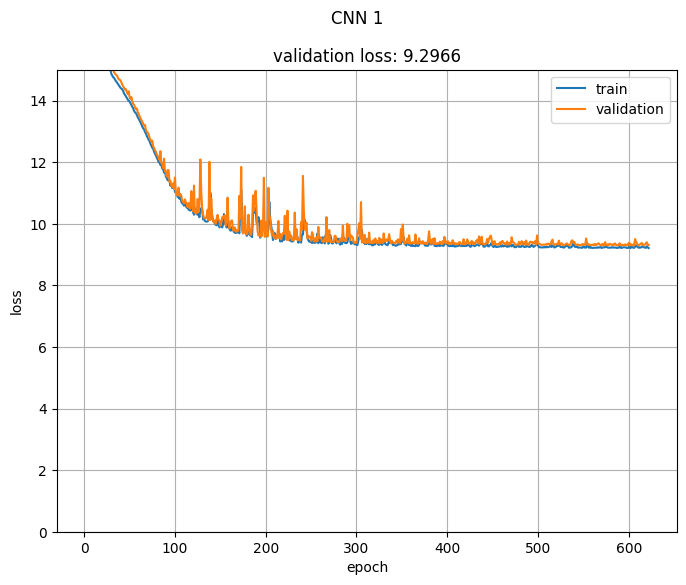

In [18]:
plot_history(history, model_name, ymax=15)

219/219 [==============================] - 0s 610us/step


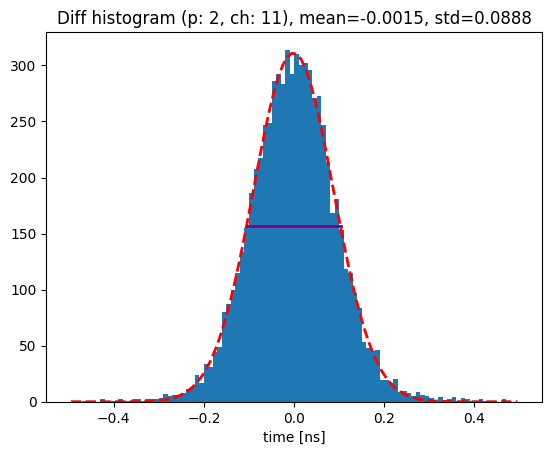

In [19]:
y_pred = model.predict(X_test)[:, 0]
std_3_hist, pcov, fwhm_3 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_3_stat = np.std(y_pred - y_test)

# Convolutional network 2

In [20]:
cnn_2_name = model_name = 'CNN 2'
model = keras.Sequential([
    layers.Input(24),
    layers.Reshape((-1, 1)),

    layers.Conv1D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),

    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),

    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),

    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=10, es_patience=60,
                      loss_weights=1000)

Epoch 1/3000
11/11 - 1s - loss: 401.0391 - val_loss: 40.5806 - lr: 0.0100 - 540ms/epoch - 49ms/step
Epoch 2/3000
11/11 - 0s - loss: 42.8233 - val_loss: 39.6515 - lr: 0.0100 - 56ms/epoch - 5ms/step
Epoch 3/3000
11/11 - 0s - loss: 24.4487 - val_loss: 25.0346 - lr: 0.0100 - 62ms/epoch - 6ms/step
Epoch 4/3000
11/11 - 0s - loss: 18.9639 - val_loss: 16.8427 - lr: 0.0100 - 65ms/epoch - 6ms/step
Epoch 5/3000
11/11 - 0s - loss: 16.1610 - val_loss: 15.4885 - lr: 0.0100 - 58ms/epoch - 5ms/step
Epoch 6/3000
11/11 - 0s - loss: 15.2809 - val_loss: 15.2553 - lr: 0.0100 - 59ms/epoch - 5ms/step
Epoch 7/3000
11/11 - 0s - loss: 15.0391 - val_loss: 15.1671 - lr: 0.0100 - 57ms/epoch - 5ms/step
Epoch 8/3000
11/11 - 0s - loss: 14.9318 - val_loss: 15.0790 - lr: 0.0100 - 60ms/epoch - 5ms/step
Epoch 9/3000
11/11 - 0s - loss: 14.8564 - val_loss: 15.0037 - lr: 0.0100 - 57ms/epoch - 5ms/step
Epoch 10/3000
11/11 - 0s - loss: 14.7826 - val_loss: 14.9517 - lr: 0.0100 - 59ms/epoch - 5ms/step
Epoch 11/3000
11/11 - 0s -

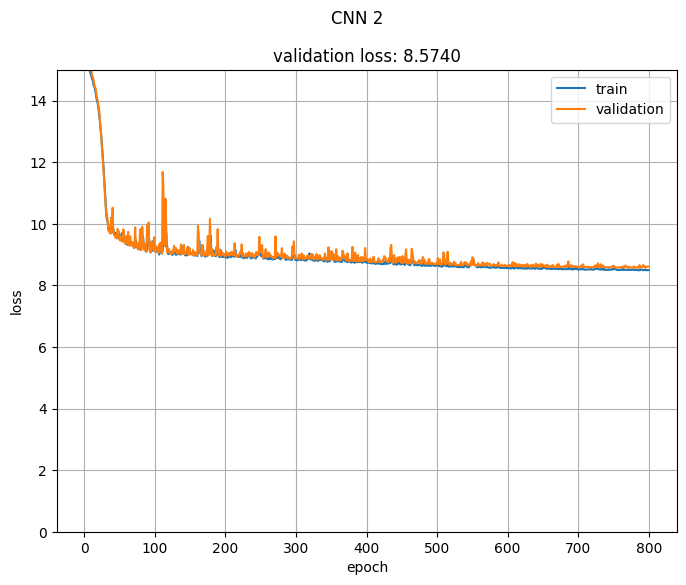

In [21]:
plot_history(history, model_name, ymax=15)

219/219 [==============================] - 0s 848us/step


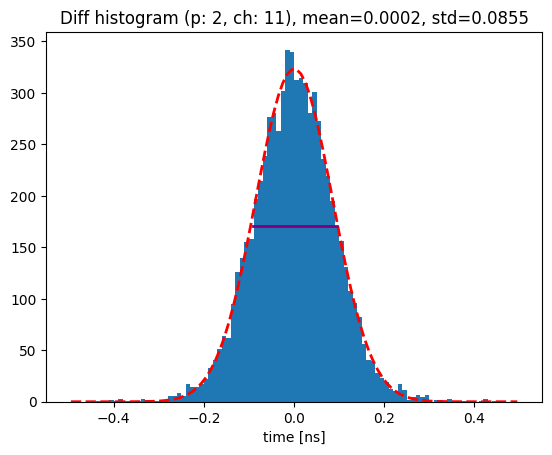

In [22]:
y_pred = model.predict(X_test)[:, 0]
std_4_hist, pcov, fwhm_4 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_4_stat = np.std(y_pred - y_test)

# UNet

In [23]:
# Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
# Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

Y_heatmap_train = np.array([dist_kernel(y) for y in y_train])
Y_heatmap_test = np.array([dist_kernel(y) for y in y_test])

In [24]:
unet_name = model_name = 'UNet'


def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D()(skip)
    return skip, x


def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    return x


###################################

inputs = layers.Input(24)
x = layers.Reshape((-1, 1))(inputs)

skip1, x = conv_block(x, 64)
skip2, x = conv_block(x, 128)
skip3, x = conv_block(x, 256)
x, _ = conv_block(x, 512)

x = deconv_block(x, skip3, 256)
x = deconv_block(x, skip2, 128)
x = deconv_block(x, skip1, 64)

x = layers.Conv1D(1, 1, activation='linear')(x)

outputs = layers.Flatten()(x)

model = tf.keras.Model(inputs, outputs)

#############################################

history = train_model(model, model_name, y_train=Y_heatmap_train, y_val=Y_heatmap_test, lr=0.001, train=False,
                      n_epochs=3000, lr_patience=10, es_patience=60, loss_weights=1000)

Epoch 1/3000
11/11 - 2s - loss: 544.2470 - val_loss: 119.0262 - lr: 0.0010 - 2s/epoch - 187ms/step
Epoch 2/3000
11/11 - 0s - loss: 82.8006 - val_loss: 45.0889 - lr: 0.0010 - 491ms/epoch - 45ms/step
Epoch 3/3000
11/11 - 0s - loss: 38.1422 - val_loss: 29.3860 - lr: 0.0010 - 486ms/epoch - 44ms/step
Epoch 4/3000
11/11 - 0s - loss: 28.8480 - val_loss: 26.6459 - lr: 0.0010 - 489ms/epoch - 44ms/step
Epoch 5/3000
11/11 - 0s - loss: 25.8109 - val_loss: 25.3236 - lr: 0.0010 - 485ms/epoch - 44ms/step
Epoch 6/3000
11/11 - 0s - loss: 24.3869 - val_loss: 23.5058 - lr: 0.0010 - 495ms/epoch - 45ms/step
Epoch 7/3000
11/11 - 0s - loss: 22.9923 - val_loss: 20.6210 - lr: 0.0010 - 487ms/epoch - 44ms/step
Epoch 8/3000
11/11 - 0s - loss: 20.9816 - val_loss: 18.7353 - lr: 0.0010 - 486ms/epoch - 44ms/step
Epoch 9/3000
11/11 - 0s - loss: 20.4176 - val_loss: 23.9129 - lr: 0.0010 - 401ms/epoch - 36ms/step
Epoch 10/3000
11/11 - 0s - loss: 20.7235 - val_loss: 30.3351 - lr: 0.0010 - 401ms/epoch - 36ms/step
Epoch 11/

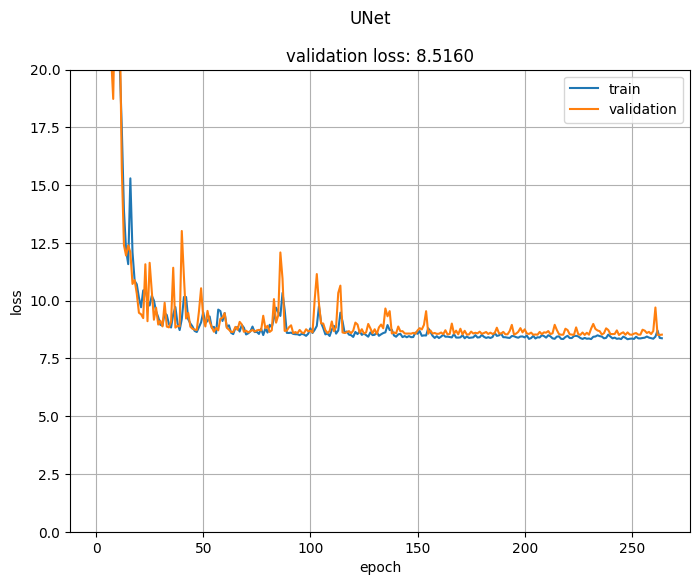

In [25]:
plot_history(history, model_name, ymax=20)

In [26]:
Y_heatmap_pred = model.predict(X_test)

y_pred = np.empty(Y_heatmap_pred.shape[0])
for i, y in enumerate(Y_heatmap_pred):
    # _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)
    y_pred[i] = get_dist_root(y)

219/219 [==============================] - 1s 3ms/step


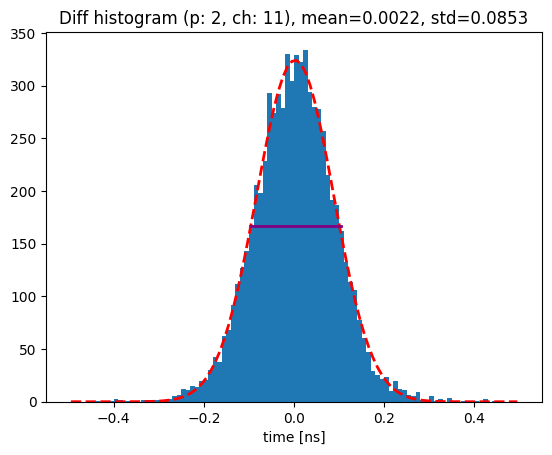

In [27]:
std_5_hist, pcov, fwhm_5 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_5_stat = np.std(y_pred - y_test)

# RNN

In [28]:
rnn_name = model_name = 'RNN'
model = keras.Sequential([
    layers.Input(24),
    layers.Reshape((-1, 1)),

    layers.LSTM(512),

    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.005, train=False, n_epochs=3000, lr_patience=10, es_patience=60,
                      loss_weights=1000)

Epoch 1/3000
11/11 - 2s - loss: 34527.0312 - val_loss: 2551.1938 - lr: 0.0050 - 2s/epoch - 137ms/step
Epoch 2/3000
11/11 - 0s - loss: 995.5614 - val_loss: 203.5876 - lr: 0.0050 - 398ms/epoch - 36ms/step
Epoch 3/3000
11/11 - 0s - loss: 71.9032 - val_loss: 63.2805 - lr: 0.0050 - 394ms/epoch - 36ms/step
Epoch 4/3000
11/11 - 0s - loss: 35.8742 - val_loss: 37.1170 - lr: 0.0050 - 404ms/epoch - 37ms/step
Epoch 5/3000
11/11 - 0s - loss: 28.2479 - val_loss: 27.2634 - lr: 0.0050 - 398ms/epoch - 36ms/step
Epoch 6/3000
11/11 - 0s - loss: 25.6674 - val_loss: 24.3653 - lr: 0.0050 - 404ms/epoch - 37ms/step
Epoch 7/3000
11/11 - 0s - loss: 24.2092 - val_loss: 23.8633 - lr: 0.0050 - 403ms/epoch - 37ms/step
Epoch 8/3000
11/11 - 0s - loss: 23.8087 - val_loss: 23.7511 - lr: 0.0050 - 398ms/epoch - 36ms/step
Epoch 9/3000
11/11 - 0s - loss: 23.6563 - val_loss: 23.7150 - lr: 0.0050 - 399ms/epoch - 36ms/step
Epoch 10/3000
11/11 - 0s - loss: 23.5995 - val_loss: 23.6955 - lr: 0.0050 - 407ms/epoch - 37ms/step
Epoc

In [29]:
# model.summary()

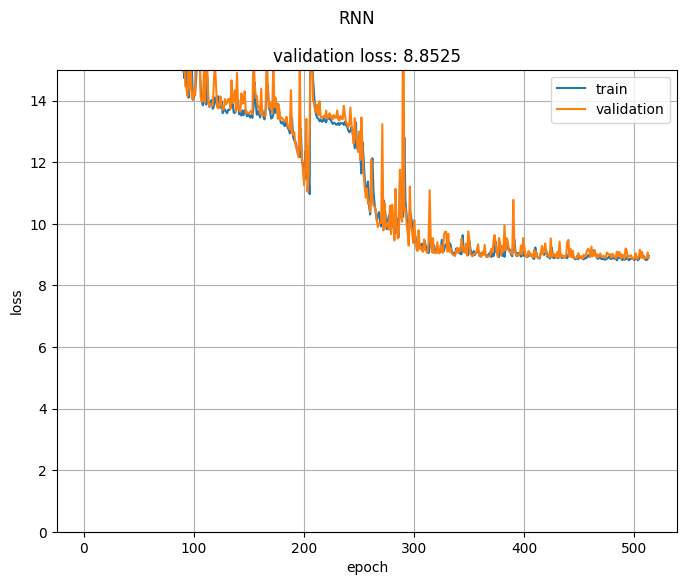

In [30]:
plot_history(history, model_name, ymax=15)

219/219 [==============================] - 1s 2ms/step


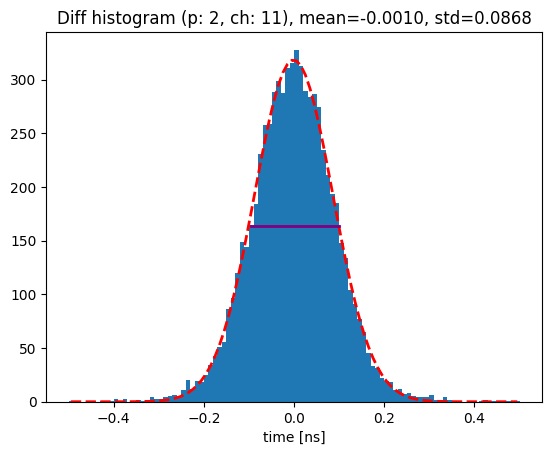

In [31]:
y_pred = model.predict(X_test)[:, 0]
std_6_hist, pcov, fwhm_6 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_6_stat = np.std(y_pred - y_test)

# Compare standard deviations

### Difference histogram – Gauss

In [32]:
compare_results([std_1_hist, std_2_hist, std_3_hist, std_4_hist, std_5_hist, std_6_hist],
                [mlp_1_name, mlp_2_name, cnn_1_name, cnn_2_name, unet_name, rnn_name], std_cfd_hist)

       CFD: 90.59 ps
      UNet: 85.31 ps (improvement: 5.82 %)
     CNN 2: 85.49 ps (improvement: 5.63 %)
       RNN: 86.81 ps (improvement: 4.17 %)
     MLP 2: 87.97 ps (improvement: 2.89 %)
     MLP 1: 88.78 ps (improvement: 1.99 %)
     CNN 1: 88.84 ps (improvement: 1.92 %)


### Stat

In [33]:
compare_results([std_1_stat, std_2_stat, std_3_stat, std_4_stat, std_5_stat, std_6_stat],
                [mlp_1_name, mlp_2_name, cnn_1_name, cnn_2_name, unet_name, rnn_name], std_cfd_stat)

       CFD: 99.86 ps
      UNet: 92.29 ps (improvement: 7.58 %)
     CNN 2: 92.60 ps (improvement: 7.28 %)
       RNN: 94.07 ps (improvement: 5.80 %)
     MLP 2: 94.28 ps (improvement: 5.59 %)
     MLP 1: 96.33 ps (improvement: 3.54 %)
     CNN 1: 96.42 ps (improvement: 3.45 %)


### Full width at half maximum (FWHM)

In [34]:
compare_results([fwhm_1, fwhm_2, fwhm_3, fwhm_4, fwhm_5, fwhm_6],
                [mlp_1_name, mlp_2_name, cnn_1_name, cnn_2_name, unet_name, rnn_name], fwhm_cfd)

       CFD: 207.42 ps
     CNN 2: 185.52 ps (improvement: 10.56 %)
       RNN: 196.02 ps (improvement: 5.50 %)
      UNet: 198.52 ps (improvement: 4.29 %)
     CNN 1: 208.32 ps (improvement: -0.43 %)
     MLP 1: 210.92 ps (improvement: -1.69 %)
     MLP 2: 215.92 ps (improvement: -4.10 %)
